<a href="https://colab.research.google.com/github/smannan/LIFXBulbAnalysis/blob/main/SmartBulbARIMAModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [13]:
!pip3 install statsmodels --upgrade

In [2]:
import pandas as pd

In [3]:
filename = '/content/drive/Shared drives/CMPE295B/JoinedPGEBulbData/2021-08-26_13_2021-09-26_22_hourly.csv'
bulb_data = pd.read_csv(filename, infer_datetime_format = True).drop(['Unnamed: 0'], axis=1, inplace=False)
bulb_data['timestamp'] = pd.to_datetime(bulb_data['timestamp'])

In [4]:
bulb_data.head()

,index,timestamp,brightness,kelvin,kWH,cost,usage,percent_usage_by_bulb,cost_per_bulb
0,0,2021-08-26 13:00:00,1.0,2700.0,0.0085,0.09,0.35,2.428571,0.002186
1,1,2021-08-26 14:00:00,1.0,2700.0,0.0085,0.11,0.38,2.236842,0.002461
2,2,2021-08-26 15:00:00,1.0,2700.0,0.0085,0.09,0.34,2.500000,0.002250
3,3,2021-08-26 16:00:00,1.0,2700.0,0.0085,0.08,0.29,2.931034,0.002345
4,4,2021-08-26 17:00:00,1.0,2700.0,0.0085,0.11,0.40,2.125000,0.002338


### Visualize time series data

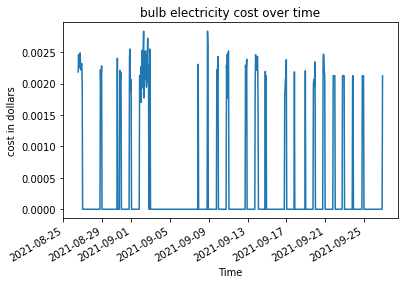

In [5]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

plt.plot(bulb_data['timestamp'], bulb_data['cost_per_bulb'])
plt.gcf().autofmt_xdate()
plt.title('bulb electricity cost over time')
plt.ylabel('cost in dollars')
plt.xlabel('Time')
plt.show()

### View autocorrelation plot
- How correlated are current timesteps to previous ones

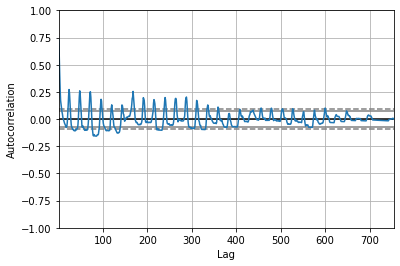

In [6]:
from pandas.plotting import autocorrelation_plot
autocorrelation_plot(bulb_data[['cost_per_bulb']])
plt.show()

- Looks like there is not a lot of correlation between timesteps?
- Confidence interval = 95% so focus on correlations within this interval as they are likely not statistical flukes


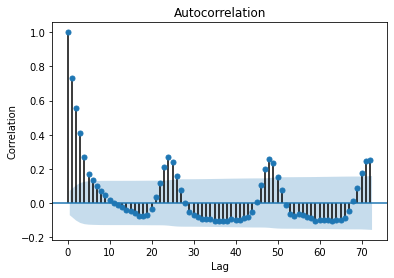

In [7]:
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(bulb_data[['cost_per_bulb']], lags=72)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

### View partial autocorrelation
- Removes indirect relationships between lags

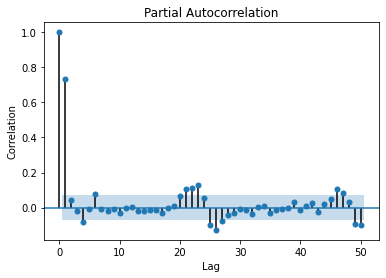

In [8]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(bulb_data[['cost_per_bulb']], lags=50)
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.show()

### Summary
- ACF correlation should be strong for the first k lags then taper off
- PACF should have *no* correlation after k
- Want data to be stationary - remove any trends beforehand analysis
- Ex correlation plots: https://www.itl.nist.gov/div898/handbook/eda/section3/autocopl.htm

In [9]:
arima_df = bulb_data[['timestamp', 'cost_per_bulb']]
arima_df.index = arima_df['timestamp']
arima_df.drop('timestamp', axis=1, inplace=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4174: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [14]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(arima_df, order=(5,1,0))
model_fit = model.fit()
print(model_fit.summary())

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:527: ValueWarning: No frequency information was provided, so inferred frequency H will be used.
  % freq, ValueWarning)


                               SARIMAX Results                                
Dep. Variable:          cost_per_bulb   No. Observations:                  754
Model:                 ARIMA(5, 1, 0)   Log Likelihood                4581.746
Date:                Thu, 30 Sep 2021   AIC                          -9151.493
Time:                        04:58:25   BIC                          -9123.748
Sample:                    08-26-2021   HQIC                         -9140.804
                         - 09-26-2021                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2046      0.027     -7.601      0.000      -0.257      -0.152
ar.L2         -0.1141      0.027     -4.213      0.000      -0.167      -0.061
ar.L3         -0.0649      0.056     -1.156      0.2

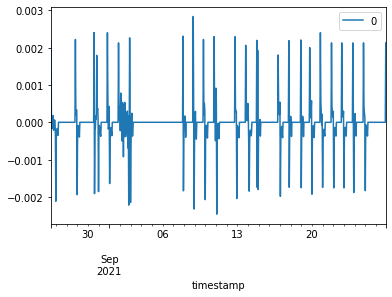

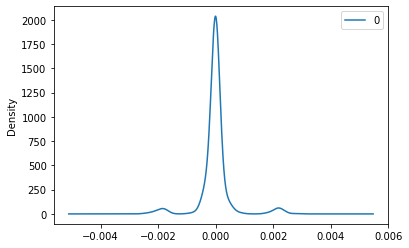

In [22]:
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
# density plot of residuals
residuals.plot(kind='kde')

In [23]:
# summary stats of residuals
residuals.describe()

,0
count,7.540000e+02
mean,7.657556e-07
std,5.567463e-04
min,-2.457845e-03
25%,-5.391861e-22
50%,-9.095577e-213
75%,3.026859e-38
max,2.833333e-03
